* 封裝了一些方法的範例

In [1]:
from collections import namedtuple, OrderedDict
from functools import reduce


class StockTradeDays(object):
    """
    股票交易日資料類別：
    - 根據價格序列建立日期、漲跌幅等資訊
    - 使用 OrderedDict 與 namedtuple 組合成結構化資料
    - 支援篩選、統計與容器型操作
    """

    def __init__(self, price_array, start_date, date_array=None):
        """
        初始化：
        :param price_array: 價格序列（list of str 或 float）
        :param start_date: 起始日期
        :param date_array: （可選）自訂日期序列
        """
        # 私有屬性：價格、日期、漲跌幅
        self.__price_array = price_array
        self.__date_array = self._init_days(start_date, date_array)
        self.__change_array = self.__init_change()

        # 建立有序股票資料字典
        self.stock_dict = self._init_stock_dict()

    # -----------------------------------------------------------------
    # 私有方法：由價格序列計算漲跌幅變化
    # -----------------------------------------------------------------
    def __init_change(self):
        """
        從 price_array 生成漲跌幅序列 change_array
        :return: list of 漲跌幅（第一天為 0）
        """
        price_float_array = [float(price_str) for price_str in self.__price_array]

        # 相鄰收盤價配對成 (前一天, 當天)
        pp_array = [(price1, price2) for price1, price2 in zip(price_float_array[:-1],
                                                               price_float_array[1:])]

        # 計算每日漲跌幅 = (b - a) / a
        change_array = list(map(
            lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp),
            pp_array
        ))

        # 插入第一天（無漲跌幅）
        change_array.insert(0, 0)
        return change_array

    # -----------------------------------------------------------------
    # protected 方法：初始化日期序列
    # -----------------------------------------------------------------
    def _init_days(self, start_date, date_array):
        """
        建立日期序列
        :param start_date: 初始日期
        :param date_array: 外部給定日期序列
        :return: list of 日期字串
        """
        if date_array is None:
            # 若未提供 date_array，根據 start_date + index 自動生成
            date_array = [str(start_date + ind) for ind, _ in enumerate(self.__price_array)]
        else:
            # 若外部已給，轉成字串列表
            date_array = [str(date) for date in date_array]
        return date_array

    # -----------------------------------------------------------------
    # 初始化股票資料 OrderedDict
    # -----------------------------------------------------------------
    def _init_stock_dict(self):
        """
        使用 namedtuple + OrderedDict 將資料組裝成結構化對象
        """
        stock_namedtuple = namedtuple('stock', ('date', 'price', 'change'))

        stock_dict = OrderedDict(
            (date, stock_namedtuple(date, price, change))
            for date, price, change in zip(
                self.__date_array, self.__price_array, self.__change_array
            )
        )
        return stock_dict

    # -----------------------------------------------------------------
    # 功能方法：篩選與統計
    # -----------------------------------------------------------------
    def filter_stock(self, want_up=True, want_calc_sum=False):
        """
        根據漲跌幅篩選資料
        :param want_up: 是否篩選上漲日
        :param want_calc_sum: 是否計算漲跌幅總和
        :return: 子集 (filter object) 或 總和 (float)
        """
        filter_func = (lambda day: day.change > 0) if want_up else (
                      lambda day: day.change < 0)

        want_days = filter(filter_func, self.stock_dict.values())

        if not want_calc_sum:
            return list(want_days)

        change_sum = sum(day.change for day in want_days)
        return round(change_sum, 3)

    # -----------------------------------------------------------------
    # 魔術方法（讓類別像容器一樣操作）
    # -----------------------------------------------------------------
    def __str__(self):
        """當 print() 或轉字串時顯示的內容"""
        return str(self.stock_dict)

    __repr__ = __str__  # 在互動式環境下顯示同樣內容

    def __iter__(self):
        """允許 for day in obj 迭代"""
        for key in self.stock_dict:
            yield self.stock_dict[key]

    def __getitem__(self, ind):
        """允許用索引方式存取"""
        date_key = self.__date_array[ind]
        return self.stock_dict[date_key]

    def __len__(self):
        """允許用 len(obj) 查詢資料筆數"""
        return len(self.stock_dict)


In [2]:
price_data = ["10", "10.5", "10.2", "11.0"]
start_date = 20250101

stock = StockTradeDays(price_data, start_date)

# 查看內容
print(stock)  # OrderedDict([...])

# 查看筆數
print(len(stock))  # 4

# 取出第 2 筆資料
print(stock[1])  # stock(date='20250102', price='10.5', change=0.05)

# 篩選上漲日
up_days = stock.filter_stock(want_up=True)
for d in up_days:
    print(d)

# 計算總漲幅
sum_up = stock.filter_stock(want_up=True, want_calc_sum=True)
print(sum_up)


OrderedDict({'20250101': stock(date='20250101', price='10', change=0), '20250102': stock(date='20250102', price='10.5', change=0.05), '20250103': stock(date='20250103', price='10.2', change=-0.029), '20250104': stock(date='20250104', price='11.0', change=0.078)})
4
stock(date='20250102', price='10.5', change=0.05)
stock(date='20250102', price='10.5', change=0.05)
stock(date='20250104', price='11.0', change=0.078)
0.128


## Python抽象類別

In [3]:
import six
from abc import ABCMeta, abstractmethod

# 一個交易策略的抽象類別（實際上是介面的功能，實作這個類別的class必須實作方法）
class TradeStrategyBase(six.with_metaclass(ABCMeta, object)):
    @abstractmethod
    def buy_strategy(self, *args, **kwargs):
        pass
    @abstractmethod
    def sell_strategy(self, *args, **kwargs):
        pass

# 實作交易策略抽象類別
class TradeStrategy1(TradeStrategyBase):
    """
    交易策略1：追漲策略
    當股價上漲超過指定閾值（預設7%）時買入，
    並持有固定天數（預設20天）後賣出。
    """

    # 類別屬性（全體策略共用，若修改TradeStrategy1.s_keep_stock_threshold，則所有策略(s1 = TradeStrategy1()、s2 = TradeStrategy2())都會受影響）
    s_keep_stock_threshold = 20  # 持股天數上限

    def __init__(self):
        self.keep_stock_day = 0               # 已持股天數
        self.__buy_change_threshold = 0.07    # 買入漲幅閾值（7%）

    # ------------------- 買入邏輯 -------------------
    def buy_strategy(self, trade_ind, trade_day, trade_days):
        """
        若目前未持股，且今日漲幅超過閾值 → 買入
        若已持股 → 繼續持有
        """
        if self.keep_stock_day == 0 and trade_day.change > self.__buy_change_threshold:
            self.keep_stock_day += 1
        elif self.keep_stock_day > 0:
            self.keep_stock_day += 1

    # ------------------- 賣出邏輯 -------------------
    def sell_strategy(self, trade_ind, trade_day, trade_days):
        """
        若持股天數 >= 持股上限 → 賣出
        """
        if self.keep_stock_day >= TradeStrategy1.s_keep_stock_threshold:
            self.keep_stock_day = 0

    # ------------------- 屬性封裝 (property) -------------------
    # 類似Java的getter和setter
    @property
    def buy_change_threshold(self):
        """讀取漲幅閾值"""
        return self.__buy_change_threshold

    @buy_change_threshold.setter
    def buy_change_threshold(self, buy_change_threshold):
        """設定漲幅閾值（限定 float 類型、保留兩位小數）"""
        if not isinstance(buy_change_threshold, float):
            raise TypeError('buy_change_threshold must be float!')
        self.__buy_change_threshold = round(buy_change_threshold, 2)

In [4]:
class TradeLoopBack:
    """
    交易回測系統 (Backtesting System)
    """

    def __init__(self, trade_days, trade_strategy):
        """
        初始化回測系統
        :param trade_days: StockTradeDays 交易資料序列
        :param trade_strategy: TradeStrategyBase 交易策略實例
        """
        self.trade_days = trade_days              # 股票交易資料（每天的收盤價、漲跌幅）
        self.trade_strategy = trade_strategy      # 策略物件 (例如 TradeStrategy1)
        self.profit_array = []                    # 儲存每日盈虧結果

    def execute_trade(self):
        """
        執行交易回測主流程
        """
        for ind, day in enumerate(self.trade_days):
            # 以日期為主軸的回測循環
            if self.trade_strategy.keep_stock_day > 0:
                # 若策略目前有持股，記錄當天的漲跌幅作為盈虧
                self.profit_array.append(day.change)

            # --- 執行買入策略 ---
            if hasattr(self.trade_strategy, 'buy_strategy'):
                self.trade_strategy.buy_strategy(ind, day, self.trade_days)

            # --- 執行賣出策略 ---
            if hasattr(self.trade_strategy, 'sell_strategy'):
                self.trade_strategy.sell_strategy(ind, day, self.trade_days)


In [11]:
# 使用TSLA-2020_2021資料進行回測
import pandas as pd

# 讀取 CSV
tsla_df = pd.read_csv('data/tsla_df_dummies.csv')
tsla_df.head()


,Date,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive
0,2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500,3,NaN,0
1,2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500,4,2.963326,1
2,2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000,0,1.925464,1
3,2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500,1,3.880052,1
4,2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500,2,4.920483,1


總交易天數： 505
持股天數： 253
總盈虧為153.29999999999998%


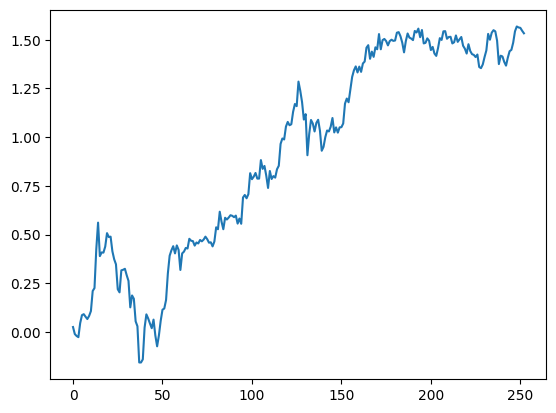

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 構建交易資料
trade_days = StockTradeDays(
    price_array=tsla_df['Close'].values,
    start_date=tsla_df['Date'].iloc[0],
    date_array=tsla_df['Date'].values
)

# 建立策略與回測引擎
strategy = TradeStrategy1()
loopback = TradeLoopBack(trade_days, strategy)

# 執行回測
loopback.execute_trade()

print("總交易天數：", len(trade_days))
print("持股天數：", len(loopback.profit_array))
print("總盈虧為{}%".format(sum(loopback.profit_array) * 100))

plt.plot(np.array(loopback.profit_array).cumsum())